# 🎼 Deep Learning for Music Generation: LSTM Implementation

This notebook explores **music generation using a Long Short-Term Memory (LSTM) network**.  
We aim to model symbolic music (MIDI) as a sequence prediction task, where the network learns to generate new notes based on past context.  

### Objectives
- Preprocess MIDI files into sequences of note tokens (pitch, hold, rest).
- Train an LSTM model to predict the next token given a sequence.
- Generate new music by sampling from the trained model.
- Save results as MIDI files for listening and evaluation.

### Why LSTM?
- LSTMs are well-suited for sequence data and can capture temporal dependencies.
- They serve as a **baseline model** for music generation.
- Later, we will compare LSTM’s performance against **Transformer models** to analyze differences in handling long-term musical structure.


In [1]:

#2) Install dependencies
!pip -q install torch torchvision torchaudio
!pip -q install scipy pretty_midi music21 tqdm matplotlib

# Step 1: Import liberaries

In [2]:
# This block sets up the environment so the rest of your code can load data,
# train models, and give repeatable results — while automatically using GPU if available.
#import

import os, math, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

import torch
from torch.utils.data import Dataset, DataLoader

# ---- Reproducibility (important for research) ----
#Ensures that experiments are deterministic (same input → same output).
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [3]:
#Project config (kept simple for now)

CFG = {
    # LSTM will predict next time-step's active pitches (multi-label)
    "seq_len": 128,        # training window length in time steps
    "batch_size": 32,      # tune based on GPU memory
    "pitch_min": 21,       # MIDI A0
    "pitch_max": 108,      # MIDI C8
}
CFG


{'seq_len': 128, 'batch_size': 32, 'pitch_min': 21, 'pitch_max': 108}

In [4]:
#Locate Nottingham.mat robustly
# We search the Kaggle "input" area to avoid hard-coding a dataset slug.
candidates = list(Path("/kaggle/input").rglob("Nottingham.mat"))
assert len(candidates) > 0, "Nottingham.mat not found under /kaggle/input. Did you attach the dataset?"
MAT_PATH = candidates[0]
print("Using:", MAT_PATH)



Using: /kaggle/input/nottingham-music/Nottingham.mat


# Step 2 : Loading Dataset
This code loads a MATLAB .mat dataset, extracts training/validation/test splits, and defines a helper to print detailed metadata about each dataset (type, shape, dtype, and first few elements).

In [5]:
from scipy.io import loadmat
import numpy as np
from pathlib import Path

# Re-load with options that flatten MATLAB cells/structs where possible
mat = loadmat(MAT_PATH, squeeze_me=True, struct_as_record=False)

print("Top-level keys:", [k for k in mat.keys() if not k.startswith("__")])
train_raw = mat.get("traindata")
valid_raw = mat.get("validdata")
test_raw  = mat.get("testdata")

def describe(name, arr):
    if arr is None:
        print(f"{name}: None")
        return
    print(f"\n{name}: type={type(arr)}, dtype={getattr(arr,'dtype',None)}, shape={getattr(arr,'shape',None)}")
    # Peek into first few elements if it's an array-like container
    try:
        if isinstance(arr, np.ndarray):
            n = min(arr.size, 3)
            # index safely even if 1D
            flat = arr.ravel()
            for i in range(n):
                elem = flat[i]
                print(f"  {name}[{i}] -> type={type(elem)}, "
                      f"ndim={getattr(elem,'ndim',None)}, "
                      f"shape={getattr(elem,'shape',None)}, "
                      f"dtype={getattr(elem,'dtype',None)}")
                if hasattr(elem, 'dtype') and isinstance(elem.dtype, np.dtype) and elem.dtype.names:
                    print("   fields:", elem.dtype.names)
                # If it’s a numpy.void (MATLAB struct), show its attributes
                if hasattr(elem, '__dict__') and elem.__dict__:
                    print("   has __dict__ keys:", list(elem.__dict__.keys()))
    except Exception as e:
        print(f"  (describe error: {e})")

describe("traindata", train_raw)
describe("validdata", valid_raw)
describe("testdata",  test_raw)


Top-level keys: ['traindata', 'validdata', 'testdata']

traindata: type=<class 'numpy.ndarray'>, dtype=object, shape=(694,)
  traindata[0] -> type=<class 'numpy.ndarray'>, ndim=2, shape=(192, 88), dtype=uint8
  traindata[1] -> type=<class 'numpy.ndarray'>, ndim=2, shape=(194, 88), dtype=uint8
  traindata[2] -> type=<class 'numpy.ndarray'>, ndim=2, shape=(192, 88), dtype=uint8

validdata: type=<class 'numpy.ndarray'>, dtype=object, shape=(173,)
  validdata[0] -> type=<class 'numpy.ndarray'>, ndim=2, shape=(192, 88), dtype=uint8
  validdata[1] -> type=<class 'numpy.ndarray'>, ndim=2, shape=(194, 88), dtype=uint8
  validdata[2] -> type=<class 'numpy.ndarray'>, ndim=2, shape=(194, 88), dtype=uint8

testdata: type=<class 'numpy.ndarray'>, dtype=object, shape=(170,)
  testdata[0] -> type=<class 'numpy.ndarray'>, ndim=2, shape=(192, 88), dtype=uint8
  testdata[1] -> type=<class 'numpy.ndarray'>, ndim=2, shape=(192, 88), dtype=uint8
  testdata[2] -> type=<class 'numpy.ndarray'>, ndim=2, shape=

In [6]:
import numpy as np

# These arrays were loaded from the .mat file earlier.
# They are object arrays, each element is a piano-roll matrix (T, 88):
# - T = number of time steps (varies per song)
# - 88 = number of piano keys (A0–C8)
train_raw = mat["traindata"]   # shape: (694,) object array
valid_raw = mat["validdata"]   # shape: (173,)
test_raw  = mat["testdata"]    # shape: (170,)

def as_binary_float32_list(obj_arr):
    """
    Convert a MATLAB-style object array of piano-rolls into a clean Python list.
    Each element:
      - Starts as (T, 88) uint8 with arbitrary counts/values
      - Gets thresholded to binary {0,1}
      - Casted to float32 for ML compatibility
    """
    rolls = []
    for i in range(obj_arr.shape[0]):     # iterate over songs
        R = np.array(obj_arr[i])          # ensure it's a NumPy array (T, 88)
        R = (R > 0).astype(np.float32)    # convert to binary 0/1, cast to float32
        rolls.append(R)                   # add cleaned piano-roll to list
    return rolls

# Convert each split into a list of binary float32 arrays
train_rolls = as_binary_float32_list(train_raw)
valid_rolls = as_binary_float32_list(valid_raw)
test_rolls  = as_binary_float32_list(test_raw)

def stats(rolls):
    """
    Compute summary statistics for a list of piano-rolls:
    - num     = how many songs
    - min_T   = shortest song length (time steps)
    - median_T= typical song length
    - max_T   = longest song length
    - P       = pitch dimension (should be 88 for piano)
    """
    lengths = [r.shape[0] for r in rolls]  # number of time steps per song
    return {
        "num": len(rolls),
        "min_T": int(np.min(lengths)),
        "median_T": int(np.median(lengths)),
        "max_T": int(np.max(lengths)),
        "P": int(rolls[0].shape[1]) if rolls else None
    }

# Print dataset stats for sanity-check
print("TRAIN:", stats(train_rolls))
print("VALID:", stats(valid_rolls))
print("TEST :", stats(test_rolls))


TRAIN: {'num': 694, 'min_T': 40, 'median_T': 255, 'max_T': 1788, 'P': 88}
VALID: {'num': 173, 'min_T': 96, 'median_T': 255, 'max_T': 1473, 'P': 88}
TEST : {'num': 170, 'min_T': 63, 'median_T': 255, 'max_T': 1793, 'P': 88}


# Listening sample input piano notes
This script turns the Nottingham dataset into listenable MIDI files.
It lets you pick train, valid, or test, chooses a few songs, converts them from (T, 88) piano-rolls to MIDI, and saves them.

In [7]:
# ==========================================================
# Export 5 Nottingham piano-roll inputs to MIDI (listenable)
# ----------------------------------------------------------
# - Loads Nottingham.mat robustly (handles singleton dims).
# - Lets you choose split: "train" | "valid" | "test".
# - Exports up to N songs as .mid (polyphonic).
# - Maps columns 0..87 -> MIDI pitches 21..108 (A0..C8).
# - Uses constant time per frame for quick playback.
# ==========================================================

import numpy as np
import scipy.io
import pretty_midi
import random

# ---------------------------
# Config (change as desired)
# ---------------------------
DATA_PATH     = "/kaggle/input/nottingham-music/Nottingham.mat"
SPLIT         = "train"          # "train" | "valid" | "test"
NUM_SONGS     = 5                # export up to this many songs
SEC_PER_FRAME = 0.25             # demo timing: 0.25s per time step
MIDI_PROGRAM  = 0                # 0 = Acoustic Grand Piano

# ---------------------------
# Utilities
# ---------------------------
def load_nottingham(path: str):
    """
    Load .mat and return splits as 1D object arrays of shape (N,).
    This handles common MATLAB singleton-dimension quirks.
    """
    mat = scipy.io.loadmat(path, squeeze_me=True, struct_as_record=False)

    def _get(key):
        arr = np.asarray(mat[key]).squeeze()
        # In rare cases squeezing could yield a scalar; wrap back as object array
        if arr.ndim == 0:
            arr = np.array([arr.item()], dtype=object)
        return arr

    return _get('traindata'), _get('validdata'), _get('testdata')

def pick_split(train, valid, test, split_name: str):
    split_name = split_name.lower()
    if split_name.startswith("train"):
        return train, "traindata"
    if split_name.startswith("valid"):
        return valid, "validdata"
    if split_name.startswith("test"):
        return test, "testdata"
    raise ValueError("SPLIT must be one of: train | valid | test")

def pianoroll_to_midi(song_roll: np.ndarray,
                      sec_per_frame: float = 0.25,
                      program: int = 0) -> pretty_midi.PrettyMIDI:
    """
    Convert a (T, 88) piano-roll (uint8/bool) into a PrettyMIDI object.
    Assumes columns map to MIDI pitches 21..108 inclusive.
    Uses fixed-duration frames for quick audition.
    """
    pm = pretty_midi.PrettyMIDI()
    inst = pretty_midi.Instrument(program=program)

    # Ensure we can iterate frames as 1D (88,) arrays
    for t, frame in enumerate(song_roll):
        frame = np.asarray(frame).ravel()  # shape -> (88,)
        # active notes at this frame (binary on/off)
        active_cols = np.flatnonzero(frame > 0)
        if active_cols.size == 0:
            continue
        start = t * sec_per_frame
        end   = (t + 1) * sec_per_frame
        for c in active_cols:
            pitch = int(c) + 21  # col 0 -> MIDI 21
            inst.notes.append(pretty_midi.Note(
                velocity=80, pitch=pitch, start=start, end=end
            ))

    pm.instruments.append(inst)
    return pm

# ---------------------------
# Main
# ---------------------------
train, valid, test = load_nottingham(DATA_PATH)
split_arr, split_key = pick_split(train, valid, test, SPLIT)

n = len(split_arr)
print(f"[INFO] Split={split_key} has {n} song(s).")

k = min(NUM_SONGS, n)
if k == 0:
    raise RuntimeError(f"No songs found in {split_key}.")

# Choose k distinct indices (all if fewer than requested)
indices = random.sample(range(n), k) if n >= k else list(range(n))
print(f"[INFO] Exporting {k} song(s): indices={indices}")

for i, idx in enumerate(indices, 1):
    # Song is typically (T, 88) with uint8 values {0,1}
    song = np.asarray(split_arr[idx])
    if song.ndim != 2 or song.shape[1] != 88:
        raise ValueError(f"Unexpected song shape at {split_key}[{idx}]: {song.shape} (expected (T, 88)).")

    pm = pianoroll_to_midi(song, sec_per_frame=SEC_PER_FRAME, program=MIDI_PROGRAM)
    out_name = f"{SPLIT}_song_{i}.mid"
    pm.write(out_name)
    print(f"✅ Saved: {out_name}  (from {split_key}[{idx}] with shape {song.shape})")

print("🎧 Done. Download the .mid files and open them in MuseScore or any DAW to listen.")


[INFO] Split=traindata has 694 song(s).
[INFO] Exporting 5 song(s): indices=[654, 114, 25, 281, 250]
✅ Saved: train_song_1.mid  (from traindata[654] with shape (256, 88))
✅ Saved: train_song_2.mid  (from traindata[114] with shape (191, 88))
✅ Saved: train_song_3.mid  (from traindata[25] with shape (295, 88))
✅ Saved: train_song_4.mid  (from traindata[281] with shape (129, 88))
✅ Saved: train_song_5.mid  (from traindata[250] with shape (257, 88))
🎧 Done. Download the .mid files and open them in MuseScore or any DAW to listen.


# Step 3 : preparing sliding windows of piano-roll data 

This code prepares sliding windows of piano-roll data so the LSTM can learn to predict the next time step.

* Input = seq_len frames of notes.
* Target = same sequence shifted one step ahead.

So, we need to prepare data where:

* Input (X) = sequence of frames [t ... t+L-1]
* Target (Y) = same sequence shifted forward [t+1 ... t+L]

That way, the model learns:
* "Given the last L time steps, predict what the next step looks like."

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader

# Update config for sequence length and batch size
CFG.update({
    "seq_len": 128,     # number of time steps each sample will cover
    "batch_size": 32,   # how many samples to process in parallel
})

class MultiHotNextStepDataset(Dataset):
    """
    Creates overlapping (X, Y) training windows from a list of piano-rolls.
    - Each piano-roll: (T, 88) binary matrix
    - Input X:  frames [t .. t+L-1]
    - Target Y: frames [t+1 .. t+L]
    where L = seq_len and each frame is an 88-dim multi-hot vector.
    """
    def __init__(self, rolls, seq_len):
        self.seq_len = seq_len
        self.samples = []  # will hold (X, Y) pairs

        for R in rolls:          # loop over all songs
            T = R.shape[0]       # number of time steps in this song
            if T <= seq_len:     # skip if too short
                continue

            # Slide a window of length seq_len across the song
            for t in range(0, T - seq_len):
                # Input: current window of length seq_len
                X = R[t      : t+seq_len]      # shape (L, 88)
                # Target: same window shifted forward by 1 step
                Y = R[t+1    : t+seq_len+1]    # shape (L, 88)
                self.samples.append((X, Y))    # store training pair

    def __len__(self):
        # Total number of (X, Y) pairs created
        return len(self.samples)

    def __getitem__(self, idx):
        # Retrieve one pair and convert to PyTorch tensors
        X, Y = self.samples[idx]
        return torch.from_numpy(X), torch.from_numpy(Y)

# Build training and validation datasets
train_ds = MultiHotNextStepDataset(train_rolls, CFG["seq_len"])
valid_ds = MultiHotNextStepDataset(valid_rolls, CFG["seq_len"])

# Check how many samples were created
len(train_ds), len(valid_ds)


(88683, 23557)

# Step 4 : Wrap datasets into DataLoaders for efficient batching/shuffling

In [9]:
# Wrap datasets into DataLoaders for efficient batching/shuffling
train_dl = DataLoader(
    train_ds,
    batch_size=CFG["batch_size"],  # how many (X, Y) pairs per batch
    shuffle=True,                  # shuffle training data each epoch
    drop_last=True                 # drop the last batch if it's smaller than batch_size
)

valid_dl = DataLoader(
    valid_ds,
    batch_size=CFG["batch_size"],  # batch size for validation
    shuffle=False,                 # no shuffling for validation (deterministic)
    drop_last=False                # keep last smaller batch if needed
)

# -----------------------------------
# Peek at one batch from training set
# -----------------------------------
xb, yb = next(iter(train_dl))

# Print the shapes of X and Y
print("X batch:", xb.shape, "Y batch:", yb.shape)
# Expected:
#   X shape = (B, L, 88)
#   Y shape = (B, L, 88)
# where:
#   B = batch_size (32 here)
#   L = seq_len (128 here)
#   88 = number of piano keys (pitches)


X batch: torch.Size([32, 128, 88]) Y batch: torch.Size([32, 128, 88])


# Step 5 : Define the model 
We’ll use an LSTM that ingests (B, L, 88) multi-hot frames and predicts the next frame for each step.
* Loss: BCEWithLogitsLoss (multi-label).
* Tricks: gradient clipping, optional mixed precision, simple early stopping.

In [10]:
# ==========================================================
# Model Definition: LSTM for Multi-Label Next-Step Prediction
# ==========================================================
import torch
import torch.nn as nn

class MusicLSTM(nn.Module):
    """
    LSTM-based model for predicting the next-step piano-roll frame.
    Input  : (B, L, 88)  multi-hot piano-roll sequences
    Output : (B, L, 88)  logits representing predicted notes
    """
    def __init__(self, input_size=88, hidden_size=256, num_layers=2, dropout=0.4):
        super().__init__()
        # Linear projection: project 88-dim input to hidden_size
        self.input_proj = nn.Linear(input_size, hidden_size)   # (B,L,88) -> (B,L,H)

        # LSTM block: processes sequential context
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,      # input/output format: (B,L,H)
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=False,   # single-direction LSTM
        )

        # Dropout: regularization to prevent overfitting
        self.dropout = nn.Dropout(dropout)

        # Output projection: map hidden state back to 88 pitch logits
        self.out = nn.Linear(hidden_size, input_size)          # (B,L,H) -> (B,L,88)

        # Weight initialization (Xavier) for stable training
        nn.init.xavier_uniform_(self.input_proj.weight)
        nn.init.constant_(self.input_proj.bias, 0.)
        nn.init.xavier_uniform_(self.out.weight)
        nn.init.constant_(self.out.bias, 0.)

    def forward(self, x):
        """
        Forward pass through the network.
        x: (B,L,88) binary float tensor
        returns: (B,L,88) logits
        """
        h = self.input_proj(x)     # project input into hidden dimension
        h, _ = self.lstm(h)        # LSTM processes temporal dependencies
        h = self.dropout(h)        # apply dropout regularization
        logits = self.out(h)       # project back to 88 pitch logits
        return logits

# Instantiate model (using GPU if available)
model = MusicLSTM(input_size=88, hidden_size=192, num_layers=2, dropout=0.4).to(device)

# Count total trainable parameters (weights + biases)
param_count = sum(p.numel() for p in model.parameters())

# Print in a clear, professional way
print(f"The model has {param_count:,} trainable parameters "
      f"≈ {param_count/1e6:.3f} million.\n")


The model has 626,968 trainable parameters ≈ 0.627 million.



# Step 6 : Setting up the loss function and optimizer

In [11]:
#3.2 Loss, optimizer, and (optional) class imbalance handling
import torch

# Quick estimate of positive rate using a few batches
def estimate_pos_weight(dataloader, max_batches=10):
    pos = 0
    total = 0
    n = 0
    for xb, yb in dataloader:
        # yb is (B,L,88) with 0/1
        pos += yb.sum().item()
        total += yb.numel()
        n += 1
        if n >= max_batches: break
    pos_rate = max(pos / total, 1e-6)
    neg_rate = 1.0 - pos_rate
    # BCEWithLogitsLoss expects pos_weight for positive examples
    pos_weight = torch.tensor([neg_rate / pos_rate], dtype=torch.float32, device=device)
    return pos_weight

pos_weight = estimate_pos_weight(train_dl, max_batches=20)
print("Estimated pos_weight:", float(pos_weight))

# Estimated pos_weight: 21.36 means that notes being ON are ~21 times rarer than notes being OFF.
# The training loss will up-weight positive examples so the model doesn’t ignore them.

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # broadcast over last dim
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)


Estimated pos_weight: 21.364391326904297


# Step 7 : Train the model

In [12]:
# 3.3 Training & validation loops (AMP, clipping, early stopping) — PyTorch ≥ 2.6 safe

from time import time
import torch
import torch.nn as nn

use_amp = torch.cuda.is_available()
scaler = torch.amp.GradScaler('cuda', enabled=use_amp)  # new API

def run_epoch(model, loader, train=True, clip_grad=1.0):
    model.train(train)
    total_loss = 0.0
    total_frames = 0

    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        with torch.amp.autocast('cuda', enabled=use_amp):      # new API
            logits = model(xb)                                 # (B, L, 88)
            loss = criterion(logits, yb)                       # averaged BCE over all dims

        if train:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()

            if clip_grad is not None:
                # unscale before clipping
                scaler.unscale_(optimizer)
                nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

            scaler.step(optimizer)
            scaler.update()

        # Accumulate stats (weighted by number of elements)
        batch_frames = yb.numel()
        total_loss  += loss.detach().item() * batch_frames
        total_frames += batch_frames

    return total_loss / max(1, total_frames)


EPOCHS    = 20
patience  = 4
best_val  = float('inf')
best_path = "/kaggle/working/lstm_nottingham.pt"  # will store *weights only*
no_improve = 0

train_hist =[]
val_hist =[]
time_hist = []


for epoch in range(1, EPOCHS + 1):
    t0 = time()
    train_loss = run_epoch(model, train_dl, train=True,  clip_grad=1.0)
    val_loss   = run_epoch(model, valid_dl, train=False, clip_grad=None)
    dt = time() - t0

    train_hist.append(train_loss)
    val_hist.append(val_loss)
    time_hist.append(dt)


    print(f"[{epoch:02d}/{EPOCHS}] train_loss={train_loss:.6f}  val_loss={val_loss:.6f}  ({dt:.1f}s)")

    # Early stopping on validation loss
    if val_loss < best_val - 1e-5:
        best_val = val_loss
        no_improve = 0

        # ✅ Save *weights only* (future-proof with PyTorch 2.6+)
        torch.save(model.state_dict(), best_path)
        #print(f"  ↳ Saved best weights to {best_path}")
    else:
        no_improve += 1
        if no_improve >= patience:
            print("  ↳ Early stopping triggered.")
            break

# ✅ Load best weights (clean, no NumPy objects inside)
state_dict = torch.load(best_path, map_location=device)
model.load_state_dict(state_dict)
print("Loaded best model. Best val_loss:", best_val)
print(f"  ↳ Saved best weights to {best_path}")


[01/20] train_loss=0.721048  val_loss=0.507156  (35.1s)
[02/20] train_loss=0.488186  val_loss=0.408139  (34.7s)
[03/20] train_loss=0.409696  val_loss=0.362483  (34.5s)
[04/20] train_loss=0.369291  val_loss=0.335311  (34.6s)
[05/20] train_loss=0.343005  val_loss=0.316258  (34.8s)
[06/20] train_loss=0.324414  val_loss=0.302796  (34.7s)
[07/20] train_loss=0.310528  val_loss=0.292709  (36.7s)
[08/20] train_loss=0.299850  val_loss=0.285031  (37.7s)
[09/20] train_loss=0.291447  val_loss=0.279110  (37.5s)
[10/20] train_loss=0.284609  val_loss=0.274643  (38.7s)
[11/20] train_loss=0.278759  val_loss=0.271159  (37.4s)
[12/20] train_loss=0.273774  val_loss=0.268390  (37.6s)
[13/20] train_loss=0.269322  val_loss=0.265907  (36.4s)
[14/20] train_loss=0.265318  val_loss=0.263620  (35.4s)
[15/20] train_loss=0.261601  val_loss=0.261841  (36.1s)
[16/20] train_loss=0.258215  val_loss=0.260143  (35.4s)
[17/20] train_loss=0.255046  val_loss=0.259287  (35.2s)
[18/20] train_loss=0.252033  val_loss=0.257830  

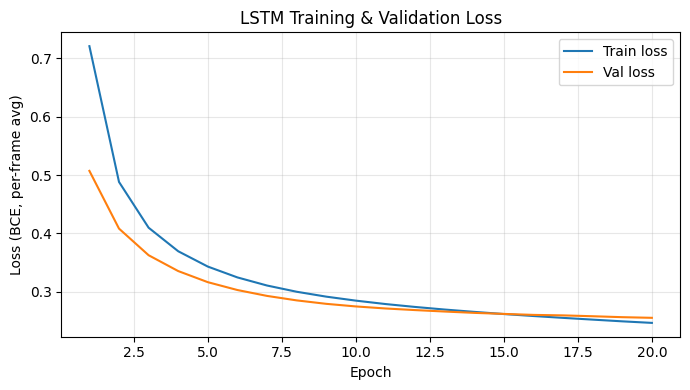

In [13]:
#plot the losess
import matplotlib.pyplot as plt

epochs = range(1, len(train_hist) + 1)

plt.figure(figsize=(7,4))
plt.plot(epochs, train_hist, label="Train loss")
plt.plot(epochs, val_hist,   label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (BCE, per-frame avg)")
plt.title("LSTM Training & Validation Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("loss_plot.png")



# Step 8 : Sample Generation 
This step takes your trained LSTM model and makes new music.

* It starts with a short seed piano-roll from validation data.
* Then, step by step, the model predicts the next notes and appends them (autoregression).
* A full piano-roll sequence is built this way.
* Finally, it’s converted to MIDI so you can listen and evaluate the model’s output.

👉 In one line: Seed in → model generates continuation → you get a MIDI file you can play.

In [14]:
#Step 4 — Generation & First Evaluations
#4.1 Define a sampler (seed → autoregressive generation)
import torch
import numpy as np
#!pip -q install pretty_midi
import pretty_midi

@torch.no_grad()
def generate_roll(model, seed_roll, steps=512, temperature=1.0, prob_threshold=0.5):
    """
    Autoregressively generate `steps` frames of an 88-dim piano-roll.
    Args:
      model          : trained LSTM (expects (B, L, 88) inputs)
      seed_roll      : (L, 88) float32 array in {0,1}
      steps          : number of frames to generate after the seed
      temperature    : >1.0 more random; <1.0 more conservative
      prob_threshold : sigmoid(logit/temperature) >= thr => note ON

    Returns:
      (L + steps, 88) numpy float32 array in {0,1}
    """
    model.eval()
    L = seed_roll.shape[0]
    ctx = torch.from_numpy(seed_roll.astype(np.float32)).unsqueeze(0).to(device)  # (1, L, 88)
    out_frames = [seed_roll.copy()]

    for _ in range(steps):
        # Predict next frame from current context
        with torch.amp.autocast('cuda', enabled=torch.cuda.is_available()):
            logits = model(ctx)[:, -1, :]                       # (1, 88)
        probs  = torch.sigmoid(logits / max(1e-6, temperature)) # temperature scaling
        next_f = (probs >= prob_threshold).float()              # binarize -> multi-hot frame

        # Append and slide context
        out_frames.append(next_f.squeeze(0).cpu().numpy())
        ctx = torch.cat([ctx, next_f.unsqueeze(1)], dim=1)
        if ctx.size(1) > L:
            ctx = ctx[:, -L:, :]

    return np.vstack(out_frames)

#4.2 Generate one sample from a validation seed
# Pick a seed from validation

seed = valid_rolls[0]
seed_len = min(192, seed.shape[0])   # a slightly longer seed often helps musicality
seed_window = seed[:seed_len]

# Sampling knobs — start with these, tweak later
gen = generate_roll(
    model,
    seed_roll=seed_window,
    steps=512,           # try 256–1024
    temperature=1.0,     # try 0.95–1.05
    prob_threshold=0.50  # try 0.45–0.55
)
gen.shape

#4.3 Export to MIDI (so you can listen 🎧)


def roll_to_midi(roll, fs=4, velocity=80, program=0):
    """
    Convert (T,88) binary piano-roll to a single-track MIDI.
    fs=4 => 4 frames/quarter-note (i.e., 16th-note quantization).
    """
    pm = pretty_midi.PrettyMIDI()
    inst = pretty_midi.Instrument(program=program)  # 0 = Acoustic Grand Piano
    PITCH_MIN = 21
    t_per_frame = 1.0 / fs

    active_start = [None] * 88
    T = roll.shape[0]

    for t in range(T):
        on = roll[t] > 0.5
        for p in range(88):
            if on[p] and active_start[p] is None:
                active_start[p] = t
            if (not on[p]) and (active_start[p] is not None):
                inst.notes.append(pretty_midi.Note(
                    velocity=velocity,
                    pitch=PITCH_MIN + p,
                    start=active_start[p] * t_per_frame,
                    end=t * t_per_frame
                ))
                active_start[p] = None

    # Close lingering notes at the end
    for p, st in enumerate(active_start):
        if st is not None:
            inst.notes.append(pretty_midi.Note(
                velocity=velocity, pitch=PITCH_MIN + p,
                start=st * t_per_frame, end=T * t_per_frame
            ))

    pm.instruments.append(inst)
    return pm

midi = roll_to_midi(gen, fs=4, velocity=80, program=0)
out_midi = "/kaggle/working/lstm_sample.mid"
midi.write(out_midi)
print("Wrote:", out_midi)


Wrote: /kaggle/working/lstm_sample.mid


# Step 9 : First Evaluations

Validation metrics @0.5  —  Precision: 0.400  Recall: 0.946  F1: 0.562
Density (active-note ratio per frame):
  Real  mean=0.0466, std=0.0043
  Gen   mean=0.1195,  std=0.0215


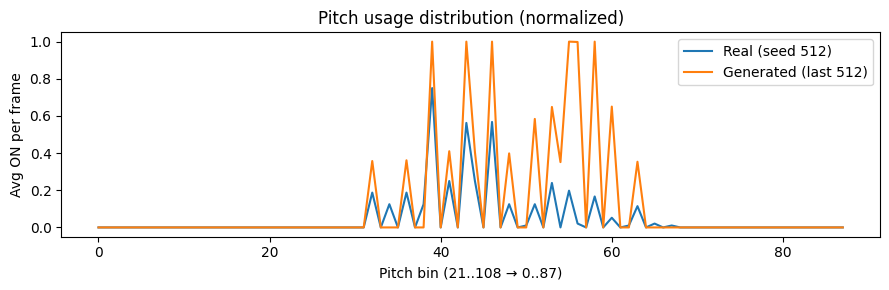

In [15]:
#4.5 First quantitative checks (simple but insightful)
#(a) Precision/Recall @0.5 on a few validation windows
import torch

@torch.no_grad()
def precision_recall_at_threshold(model, loader, thr=0.5, max_batches=50):
    model.eval()
    TP = FP = FN = 0
    n = 0
    for xb, yb in loader:
        xb = xb.to(device); yb = yb.to(device)
        with torch.amp.autocast('cuda', enabled=torch.cuda.is_available()):
            logits = model(xb)
        preds = (torch.sigmoid(logits) >= thr).float()

        TP += (preds * yb).sum().item()
        FP += (preds * (1 - yb)).sum().item()
        FN += ((1 - preds) * yb).sum().item()

        n += 1
        if n >= max_batches:
            break

    precision = TP / max(1, (TP + FP))
    recall    = TP / max(1, (TP + FN))
    f1        = 2 * precision * recall / max(1e-8, (precision + recall))
    return precision, recall, f1

p, r, f1 = precision_recall_at_threshold(model, valid_dl, thr=0.5, max_batches=50)
print(f"Validation metrics @0.5  —  Precision: {p:.3f}  Recall: {r:.3f}  F1: {f1:.3f}")

#(b) Note density (sparsity) match: real vs generated
def density(frames):  # % of active notes per frame
    # frames: (T,88) in {0,1}
    per_frame = frames.mean(axis=1)          # fraction active per frame
    return float(per_frame.mean()), float(per_frame.std())

real_mean, real_std = density(seed[:512])    # first 512 frames from real piece
gen_mean,  gen_std  = density(gen[-512:])    # last 512 frames from generated

print(f"Density (active-note ratio per frame):")
print(f"  Real  mean={real_mean:.4f}, std={real_std:.4f}")
print(f"  Gen   mean={gen_mean:.4f},  std={gen_std:.4f}")


#(c) Pitch histogram: real vs generated
import numpy as np
import matplotlib.pyplot as plt

def pitch_hist(frames):
    # frames: (T,88) {0,1}
    return frames.sum(axis=0) / max(1, frames.shape[0])

real_hist = pitch_hist(seed[:512])
gen_hist  = pitch_hist(gen[-512:])

plt.figure(figsize=(9,3))
plt.plot(real_hist, label="Real (seed 512)")
plt.plot(gen_hist,  label="Generated (last 512)")
plt.title("Pitch usage distribution (normalized)")
plt.xlabel("Pitch bin (21..108 → 0..87)")
plt.ylabel("Avg ON per frame")
plt.legend(); plt.tight_layout(); plt.show()


# Step 10 : Inference-only pipeline (LSTM)

In [16]:
# ==============================
# Inference-only pipeline (LSTM)
# ==============================

import numpy as np
import torch
import torch.nn as nn
import scipy.io
import pretty_midi
from pathlib import Path

# ---------- Device ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------- Paths (adjust as needed) ----------
DATA_PATH    = "/kaggle/input/nottingham-music/Nottingham.mat"   # nottingham .mat
WEIGHTS_PATH = "/kaggle/working/lstm_nottingham.pt"              # your saved state_dict
OUT_MIDI     = "/kaggle/working/lstm_inference_sample.mid"       # output file

# ---------- Minimal model (must match training) ----------
class MusicLSTM(nn.Module):
    """
    LSTM-based next-frame predictor over 88 pitches.
    Input  : (B, L, 88) multi-hot frames
    Output : (B, L, 88) logits
    """
    def __init__(self, input_size=88, hidden_size=192, num_layers=2, dropout=0.4):
        super().__init__()
        self.input_proj = nn.Linear(input_size, hidden_size)
        self.lstm = nn.LSTM(
            input_size=hidden_size, hidden_size=hidden_size,
            num_layers=num_layers, batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=False
        )
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(hidden_size, input_size)

        # same init as training (helps if you ever warm-start without weights)
        nn.init.xavier_uniform_(self.input_proj.weight); nn.init.constant_(self.input_proj.bias, 0.)
        nn.init.xavier_uniform_(self.out.weight);        nn.init.constant_(self.out.bias, 0.)

    def forward(self, x):
        h = self.input_proj(x)
        h, _ = self.lstm(h)
        h = self.dropout(h)
        return self.out(h)

# ---------- Load best weights ----------
model = MusicLSTM().to(device)
state = torch.load(WEIGHTS_PATH, map_location=device)
model.load_state_dict(state)
model.eval()
print("Loaded weights from:", WEIGHTS_PATH)

# ---------- Data loader (only to grab a real seed) ----------
def load_nottingham(path: str):
    """Return (train, valid, test) as 1D object arrays of piano-rolls (T,88) in {0,1}."""
    mat = scipy.io.loadmat(path, squeeze_me=True, struct_as_record=False)
    def _get(k):
        arr = np.asarray(mat[k]).squeeze()
        if arr.ndim == 0:  # rare scalar corner-case
            arr = np.array([arr.item()], dtype=object)
        return arr
    return _get('traindata'), _get('validdata'), _get('testdata')

def as_binary_float32_list(obj_arr):
    """Convert MATLAB object array to list of (T,88) float32 in {0,1}."""
    out = []
    for i in range(obj_arr.shape[0]):
        R = np.asarray(obj_arr[i])
        R = (R > 0).astype(np.float32)
        out.append(R)
    return out

train_raw, valid_raw, test_raw = load_nottingham(DATA_PATH)
valid_rolls = as_binary_float32_list(valid_raw)
print(f"Validation seeds available: {len(valid_rolls)}")

# ---------- Sampler (autoregressive generation) ----------
@torch.no_grad()
def generate_roll(model, seed_roll, steps=512, temperature=1.0, prob_threshold=0.50):
    """
    Autoregressively extend a seed piano-roll by `steps` frames.
    - seed_roll: (L,88) float32 in {0,1}
    - temperature: >1.0 => more random; <1.0 => more conservative
    - prob_threshold: sigmoid(logit/temperature) >= thr => note ON
    Returns: (L+steps, 88) float32 in {0,1}
    """
    L = seed_roll.shape[0]
    ctx = torch.from_numpy(seed_roll.astype(np.float32)).unsqueeze(0).to(device)  # (1,L,88)
    out = [seed_roll.copy()]

    amp = torch.cuda.is_available()
    for _ in range(steps):
        with torch.amp.autocast('cuda', enabled=amp):
            logits = model(ctx)[:, -1, :]                        # (1,88)
        probs  = torch.sigmoid(logits / max(1e-6, temperature))  # temperature scaling
        next_f = (probs >= prob_threshold).float()               # deterministic thresholding
        out.append(next_f.squeeze(0).cpu().numpy())
        # slide context to keep length L
        ctx = torch.cat([ctx, next_f.unsqueeze(1)], dim=1)
        if ctx.size(1) > L:
            ctx = ctx[:, -L:, :]
    return np.vstack(out)

# ---------- MIDI export ----------
def roll_to_midi(roll, fs=4, velocity=80, program=0):
    """
    Convert (T,88) binary piano-roll to a single-track MIDI.
    fs=4 => 4 frames per quarter note (16th-note grid).
    """
    pm = pretty_midi.PrettyMIDI()
    inst = pretty_midi.Instrument(program=program)  # 0 = Acoustic Grand Piano
    PITCH_MIN = 21
    t_per_frame = 1.0 / fs

    active_start = [None] * 88
    T = roll.shape[0]
    for t in range(T):
        on = roll[t] > 0.5
        for p in range(88):
            if on[p] and active_start[p] is None:
                active_start[p] = t
            if (not on[p]) and (active_start[p] is not None):
                inst.notes.append(pretty_midi.Note(
                    velocity=velocity, pitch=PITCH_MIN + p,
                    start=active_start[p] * t_per_frame,
                    end=t * t_per_frame
                ))
                active_start[p] = None
    # close lingering notes
    for p, st in enumerate(active_start):
        if st is not None:
            inst.notes.append(pretty_midi.Note(
                velocity=velocity, pitch=PITCH_MIN + p,
                start=st * t_per_frame, end=T * t_per_frame
            ))
    pm.instruments.append(inst)
    return pm

# ---------- Inference knobs ----------
SEED_INDEX     = 0         # which validation piece to seed from
SEED_LEN       = 192       # context length from the seed
STEPS          = 512       # how many new frames to generate
TEMPERATURE    = 1.00      # try 0.95–1.05
PROB_THRESHOLD = 0.50      # try 0.45–0.55 for density control
MIDI_PROGRAM   = 0         # Acoustic Grand Piano
FS             = 4         # frames per quarter note for MIDI timing

# ---------- Run inference ----------
seed_full   = valid_rolls[SEED_INDEX]
seed_window = seed_full[:min(SEED_LEN, seed_full.shape[0])]
gen_roll    = generate_roll(
    model, seed_window, steps=STEPS,
    temperature=TEMPERATURE, prob_threshold=PROB_THRESHOLD
)
print("Generated roll shape:", gen_roll.shape)

midi = roll_to_midi(gen_roll, fs=FS, velocity=80, program=MIDI_PROGRAM)
midi.write(OUT_MIDI)
print("Wrote MIDI to:", OUT_MIDI)


Device: cuda
Loaded weights from: /kaggle/working/lstm_nottingham.pt
Validation seeds available: 173
Generated roll shape: (704, 88)
Wrote MIDI to: /kaggle/working/lstm_inference_sample.mid
